# Determining Properties of Galaxies Using Machine Learning

---
## Jorge Bermeo, Nathanael Gutierrez, Tokhirjon Malikov

## Table of Contents
1. [Abstract](#Abstract)
1. [Learning Objectives](#Learning-Objectives)
1. [Unsuccessful Approaches](#Unsuccessful-Approaches)
1. [Data Visualization](#Data-Visualization)
1. [Helper Functions](#Helper-Functions)
1. [Predictions](#Predicting-Age)
    1. [Predicting age](#Predicting-Age)
    1. [Predicting tau](#Predicting-Tau)
    1. [Predicting mass](#Predicting-Mass)
    1. [Predicting dust](#Predicting-Dust)
1. [Conclusion](#Conclusion)
1. [References](#References)

---
## Abstract

The data that we have is 1000 simulated spectra of galaxies. A spectrum is a high resolution chart or graph that shows the intensity of light being emitted over a range of wavelengths. Galaxies consist of many different components, such as stars, gases, and dust. These physical properties leave a different and specific imprint on the galaxy’s spectral energy distribution. It is our hypothesis that these properties of galaxies can be determined empirically by analyzing spectral data gathered from such galaxies. We employed Machine Learning tools to determine the degree that a galaxy’s spectral energy distribution is correlated with each of the four properties being analyzed. Our results show that there exists a very strong correlation between the mass of a galaxy and its spectral energy distribution. For the dust and age properties of galaxies, a relatively strong correlation was also observed. In the case of tau, our results seem to indicate that a galaxy’s tau has little to no correlation with its spectral energy distribution. Some ways we could improve our results include using more advanced machine learning techniques and increasing the size and/or quality of our dataset.

---
# Learning Objectives

- Build a ML model that can predict four different physical properties using algorithm of our choice
    - The four different properties are as follows: Age, Tau, Stellar Mass, and Dust
- In this project we present the use of Support Vector Machine Algorithm and Decision Trees to predict the four different properties listed above
- We characterize the performance of our Machine Learning model by simulating different  noise level, seeing how the results change and determining how the model performs

---
## Unsuccessful Approaches

When choosing which algorithm could help us predict the desired properties, several unsuccessful attempts were made.  Linear Regression wasn’t efficient at predicting the desired properties.
An attempt to a Neural Network at 1,000; 100,00; and 1,000,000 runs only proved a small level of efficiency  and an exponential computing time. 

---
## Data Visualization

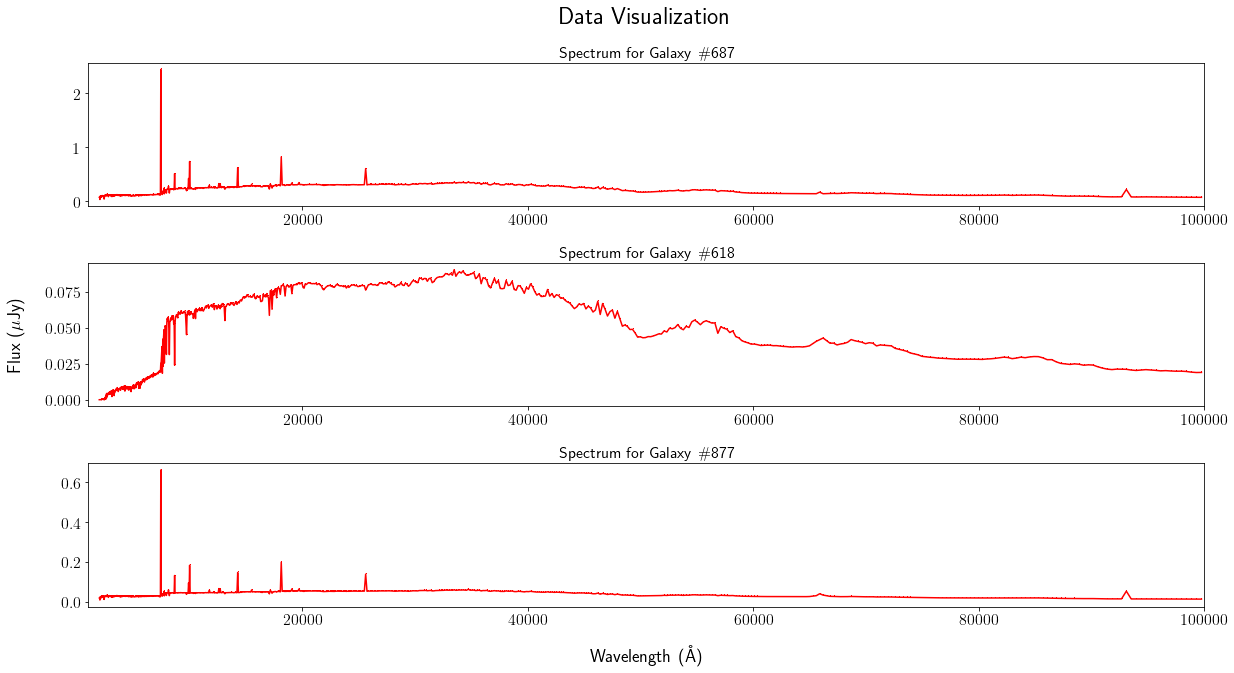

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True

spectra = pd.read_csv('spectra.dat', delimiter=' ', header=None)
wavelengths = pd.read_csv('wavelengths.csv', header=None)
galaxy_properties = pd.read_csv('galaxy_properties.csv', index_col = 0)

random.seed(1010) # for reproducibility
rows = [random.randint(0, len(spectra)) for i in range(3)]  # select three random galaxy spectrums to visualize

plt.rcParams["figure.figsize"] = (20,10) #set size of plot
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

fig = plt.figure()
ax = fig.add_subplot(111) # Generating subplots for our figure; see https://stackoverflow.com/a/6981055/3135556
ax1 = fig.add_subplot(311) # 3 rows, 1 column, plot at position 1
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(wavelengths, spectra.loc[rows[0]], 'r,-')
ax2.plot(wavelengths, spectra.loc[rows[1]], 'r,-')
ax3.plot(wavelengths, spectra.loc[rows[2]], 'r,-')

ax1.set_xlim(1000, 100000) # restrict the x-axis to mitigate the gap that exists around x=0
ax2.set_xlim(1000, 100000)
ax3.set_xlim(1000, 100000)

# Set common labels
ax.set_xlabel("Wavelength (Å)", fontsize=18, labelpad=18)
ax.set_ylabel("Flux ($\mathrm{\mu}$Jy)", fontsize=18, labelpad=36)
ax.set_title("Data Visualization", fontsize=24, pad=40)

ax1.set_title("Spectrum for Galaxy \#" + str(rows[0]), fontsize=16)
ax2.set_title("Spectrum for Galaxy \#" + str(rows[1]), fontsize=16)
ax3.set_title("Spectrum for Galaxy \#" + str(rows[2]), fontsize=16)

plt.subplots_adjust(hspace=0.4) # increase vertical distance between subplots
fig.savefig("visualization.png")

---
## Helper Functions

In [2]:
def dtt(values, val_type='pd'):
    """
    Do The Thing -- takes the log of the sum of each row in 'values'
    Returns a NumPy array with as many values as the number of rows in 'values'
    
    Positional arguments:
        values -- a Pandas DataFrame or NumPy array
        
    Optional arguments:
        val_type -- 'pd' if 'values' is a Pandas DataFrame, 'np' if 'values' is a NumPy array
    """
    
    X = np.empty(len(values))
    
    if (val_type == 'pd'):
        for i in range(len(values)):
            X[i] = np.log(np.sum(values.iloc[i]))
    elif (val_type == 'np'):
        for i in range(len(values)):
            X[i] = np.log(np.sum(values[i]))
    else:
        raise ValueError("Expecting val_type to be either 'pd' or 'np'")
    
    return X

In [3]:
def plot_model_performance(X, y_expected, y_predicted, ylabel, **kwargs):
    params = {
        'actual_color': 'red',
        'predicted_color': 'blue',
        'actual_label': 'Actual values',
        'predicted_label': 'Predicted values',
        'title': 'Model Perfomance',
        'xlabel': '$\log (\sum\limits_{i\in\{\mathrm{Spectrum}\}} \mathrm{Spectrum}_i)$',
        'save_fig': False,
        'save_fig_as': '',
        'scores': None,
        'scores_loc': (0.01, 0.98),
    }
    
    for key, value in kwargs.items():
        if key not in params:
            raise ValueError("Keyword argument '" + key + "' not in list of acceptable parameters.")
        params[key] = value
    
    fig, ax = plt.subplots()
    ax.scatter(X, y_expected, color=params['actual_color'], label=params['actual_label'], alpha=0.6)
    plt.scatter(X, y_predicted, color=params['predicted_color'], label=params['predicted_label'], alpha=0.6)
    ax.legend()
    ax.set_title(params['title'], fontsize=20, pad=10)
    ax.set_ylabel(ylabel, fontsize=16, labelpad=14)
    ax.set_xlabel(params['xlabel'], fontsize=16, labelpad=14)
    
    if params['scores'] is not None:
        props = dict(boxstyle='round', facecolor='silver', alpha=0.5)
        text = 'Training Results\n\n'
        for key, value in params['scores'].items():
            text = text + ' = '.join((key, '%.3f' % (value, ))) + '\n'
        loc = params['scores_loc']
        ax.text(loc[0], loc[1], text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    if params['save_fig']:
        if params['save_fig_as'] == '':
            params['save_fig_as'] = 'Model Performance - ' + ylabel
        fig.savefig(params['save_fig_as'], dpi=300)

In [4]:
def plot_model_training_performance(true_labels, predicted_labels, axis=None, **kwargs):
    params = {
        'title': None,
        'label': '',
        'save_fig': False,
        'save_fig_as': None,
        'scores': None,
        'scores_loc': (0.01, 0.98),
        'return_plot': False,
    }
    
    for key, value in kwargs.items():
        if key not in params:
            raise ValueError("Keyword argument '" + key + "' not in list of acceptable parameters.")
        params[key] = value
      
    if params['title'] == None:
        title = params['label'] + ' Model Training Performance'
    else:
        title = params['title']
    
    if axis == None:
        fig, ax = plt.subplots()
    else:
        ax = axis
    
    ax.scatter(predicted_labels, true_labels, color='orange', s=50)
    ax.plot([true_labels.min(), true_labels.max()], [true_labels.min(), true_labels.max()], 'k--', lw=4)
    ax.set_title(title.strip(), fontsize=20, pad=10)
    ax.set_ylabel('True values', fontsize=16, labelpad=14)
    ax.set_xlabel('Predicted values', fontsize=16, labelpad=14)
    
    if params['scores'] is not None:
        props = dict(boxstyle='round', facecolor='silver', alpha=0.5)
        text = 'Mean Training Results\n\n'
        for key, value in params['scores'].items():
            text = text + ' = '.join((key, '%.3f' % (value, ))) + '\n'
        loc = params['scores_loc']
        ax.text(loc[0], loc[1], text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    if axis == None:
        if params['save_fig']:
            if params['save_fig_as'] == None:
                params['save_fig_as'] = title
            fig.savefig(params['save_fig_as'], dpi=300)
        
        if params['return_plot']:
            return fig

In [5]:
from sklearn.model_selection import KFold

spectra_X = dtt(spectra)
cv = KFold(n_splits=5, shuffle=True, random_state=101)

In [6]:
def visualize(Y, ylabel, title, X=spectra_X, xlabel='$\log (\sum\limits_{i\in\{\mathrm{Spectrum}\}} \mathrm{Spectrum}_i)$', save_fig=False, save_as=None):
    plt.scatter(X, Y)
    plt.title(title, fontsize=20, pad=10)
    plt.xlabel(xlabel, fontsize=16, labelpad=14)
    plt.ylabel(ylabel, fontsize=16, labelpad=14)
    if save_fig == True:
        if save_as == None:
            save_as = title
        plt.savefig(save_as, dpi=300)

In [7]:
import scipy.stats

def add_noise(df, percent):
    """
    Add a percetange of noise to a Pandas DataFrame.
    Returns a new Pandas DataFrame containing the noise.
    
    Positional arguments:
    - df : a Pandas DataFrame
    - percent: percentage of noise desired, as a float. 
               For example, a value of 0.10 is 10%. 
               Similarly a value of 1.15 is 115%. 
    """
    ndf = pd.DataFrame()
    for i in range(len(df.columns)):
        mean = df[i] * percent
        gauss_dist = scipy.stats.norm.rvs(loc=0, scale=0.005, size=1000)
        ndf[i] = df[i] + np.abs(gauss_dist)
        
    return ndf

In [8]:
def plot_noise_together(model, target, label, cv, scoring=['r2', 'neg_mean_squared_error']):
    noisy_spectra = [{
        'spectrum': spectra_1,
        'noise': '$1\%$'
    }, {
        'spectrum': spectra_5,
        'noise': '$5\%$'
    }, {
        'spectrum': spectra_10,
        'noise': '$10\%$'
    }]
    
    plots = np.empty(3)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    reg_ax = fig.add_subplot(211)
    noisy_ax1 = fig.add_subplot(234)
    noisy_ax2 = fig.add_subplot(235)
    noisy_ax3 = fig.add_subplot(236)
    noisy_axes = [noisy_ax1, noisy_ax2, noisy_ax3]
    
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    ax.set_title("Comparison of " + label + " Model with Varying Degrees of Noise", fontsize=24, pad=60)
    
    cv_scores = cross_validate(model, spectra, target, cv=cv, scoring=scoring, n_jobs=-1, return_estimator=True) #Regular without noise
    prediction = cross_val_predict(model, spectra, target, cv=cv, n_jobs=-1)
    estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

    scores = {
        '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
        'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
    }

    plot_model_training_performance(target, prediction, label=label, scores=scores, axis=reg_ax)
    
    for i,val in enumerate(noisy_spectra):
        spectrum =  val['spectrum']
        cv_scores = cross_validate(model, spectrum, target, cv=cv, scoring=scoring, n_jobs=-1, return_estimator=True)
        prediction = cross_val_predict(model, spectrum, target, cv=cv, n_jobs=-1)
        estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]
        
        scores = {
            '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
            'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
        }
        
        title = label + ' Model w/ ' + val['noise'] + ' Noise'
        plot_model_training_performance(target, prediction, label=label, title=title, scores=scores, axis=noisy_axes[i])
        
    plt.subplots_adjust(hspace=0.6)
    fig.savefig(label + " Noise Performance", dpi=300)

In [9]:
spectra_1 = add_noise(spectra, 0.01)
spectra_5 = add_noise(spectra, 0.05)
spectra_10 = add_noise(spectra, 0.1)

---
## Predicting Age

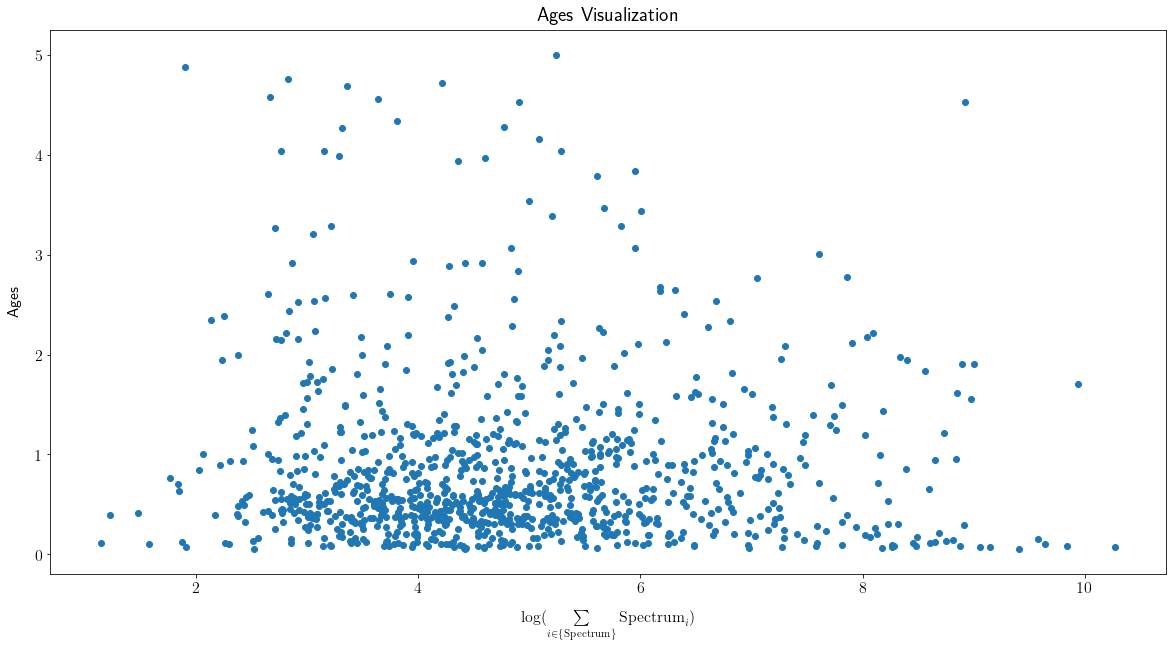

In [10]:
ages = galaxy_properties['age']
visualize(ages, 'Ages', 'Ages Visualization', save_fig=True)

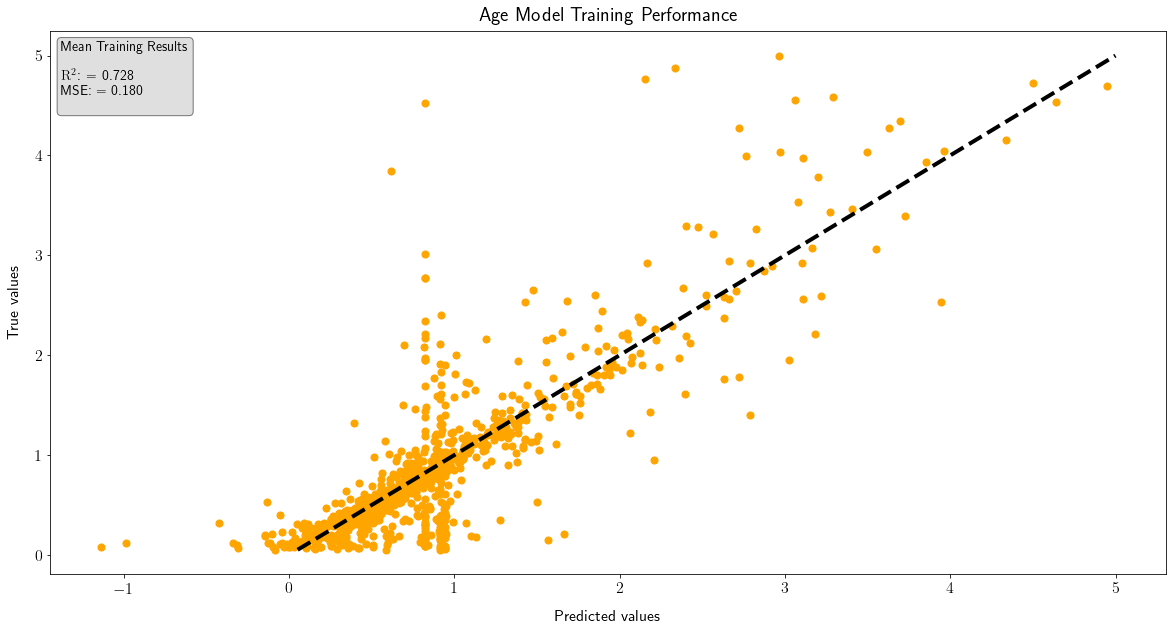

In [11]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.svm import SVR

age_model = SVR(C=2300, gamma=0.08, kernel='rbf')
cv_scores = cross_validate(age_model, spectra, ages, cv=cv, scoring=['r2', 'neg_mean_squared_error'], n_jobs=-1, return_estimator=True)
prediction = cross_val_predict(age_model, spectra, ages, cv=cv, n_jobs=-1)

estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

scores = {
     '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
     'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
}

plot_model_training_performance(ages, prediction, label='Age', scores=scores, save_fig=True)

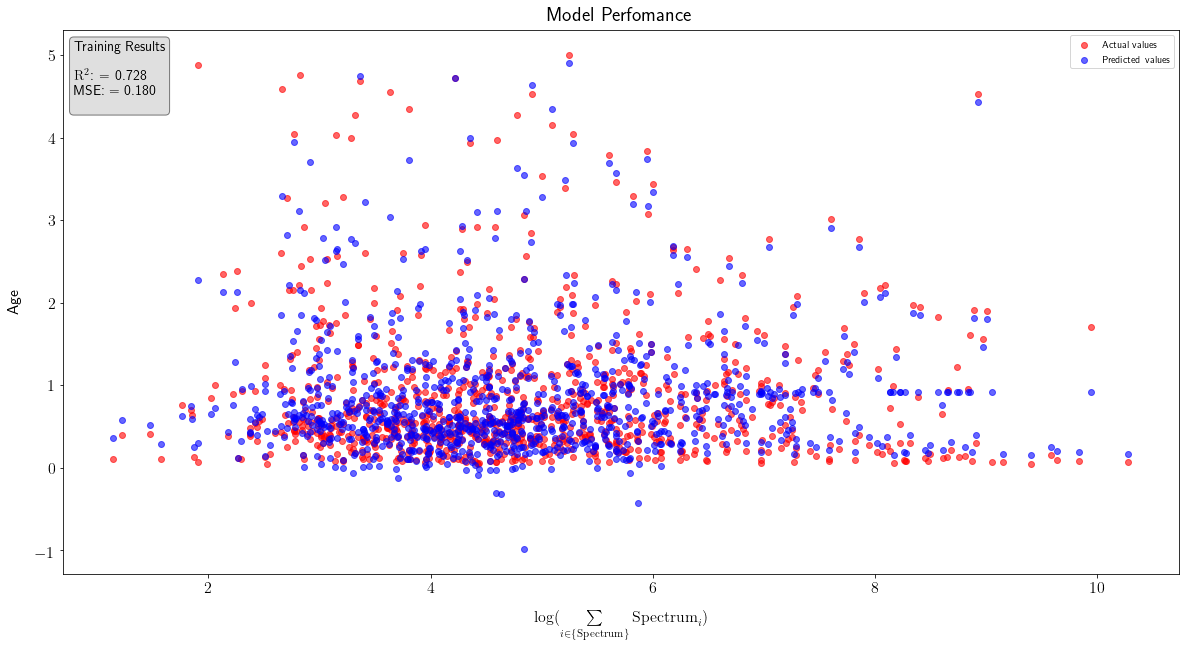

In [12]:
plot_model_performance(spectra_X, ages, estimator.predict(spectra), 'Age', scores=scores, save_fig=True)

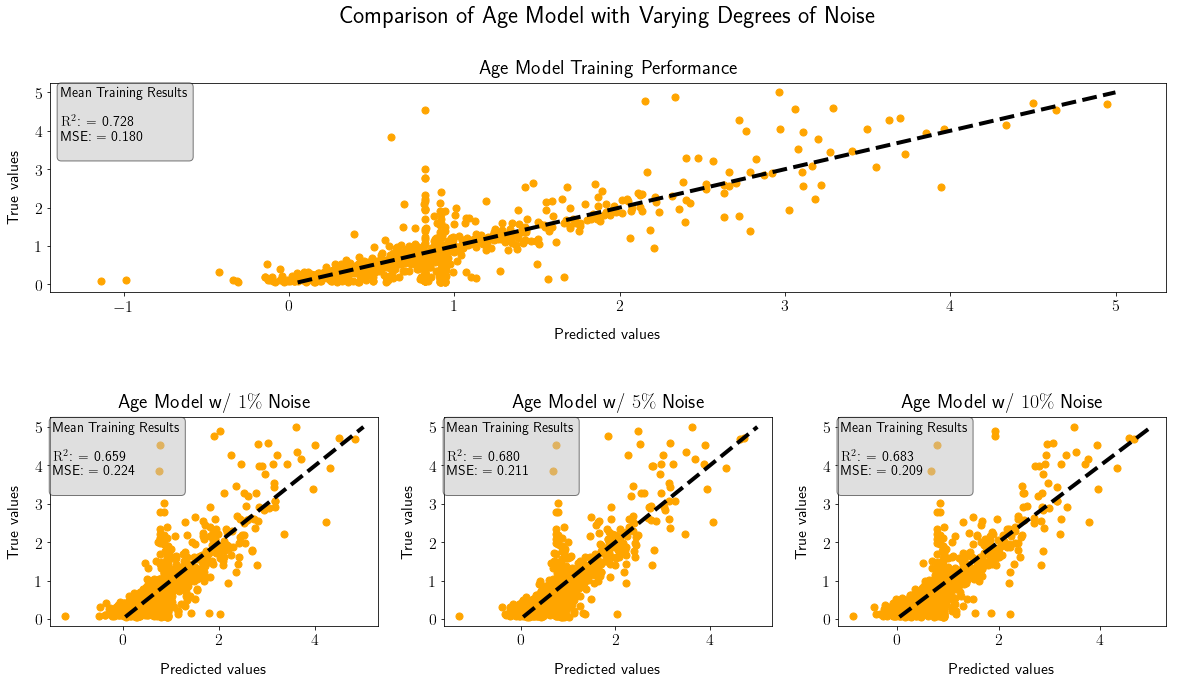

In [13]:
plot_noise_together(age_model, ages, "Age", cv)

---
## Predicting Tau

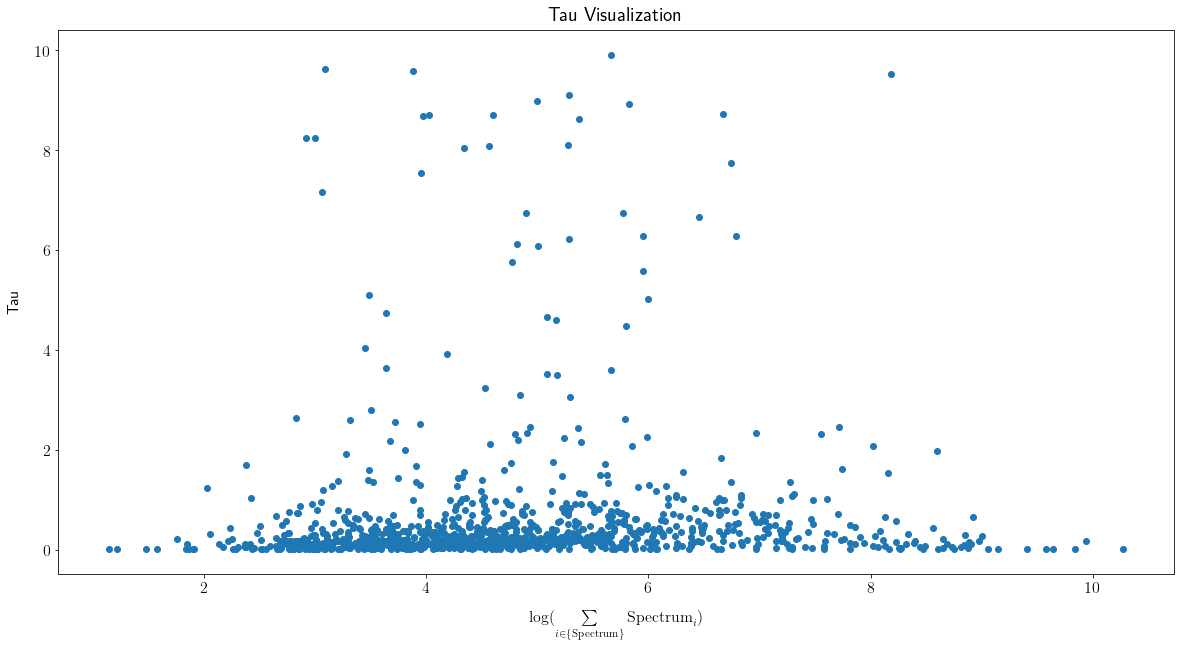

In [14]:
tau = galaxy_properties['tauGyr']
visualize(tau, 'Tau', 'Tau Visualization', save_fig=True)

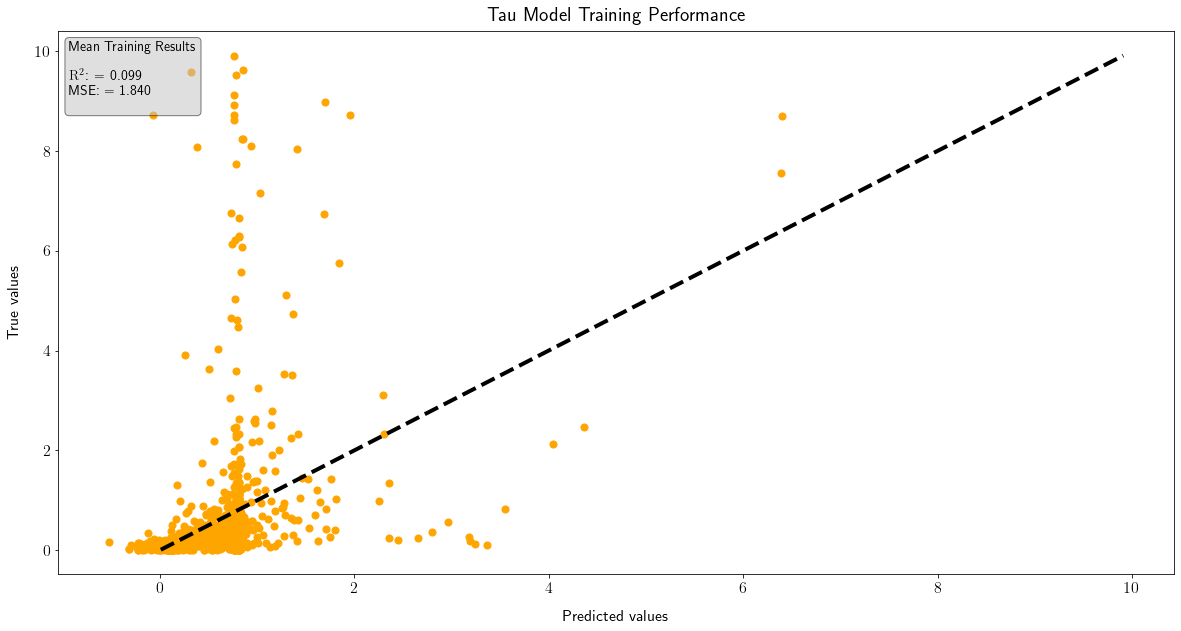

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svr = SVR(C=10, gamma=16, kernel='rbf')
tau_model = make_pipeline(StandardScaler(), svr)
cv_scores = cross_validate(tau_model, spectra, tau, cv=cv, scoring=['r2', 'neg_mean_squared_error'], n_jobs=-1, return_estimator=True)
prediction = cross_val_predict(tau_model, spectra, tau, cv=cv, n_jobs=-1)

estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

scores = {
     '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
     'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
}

plot_model_training_performance(tau, prediction, label='Tau', scores=scores, save_fig=True)

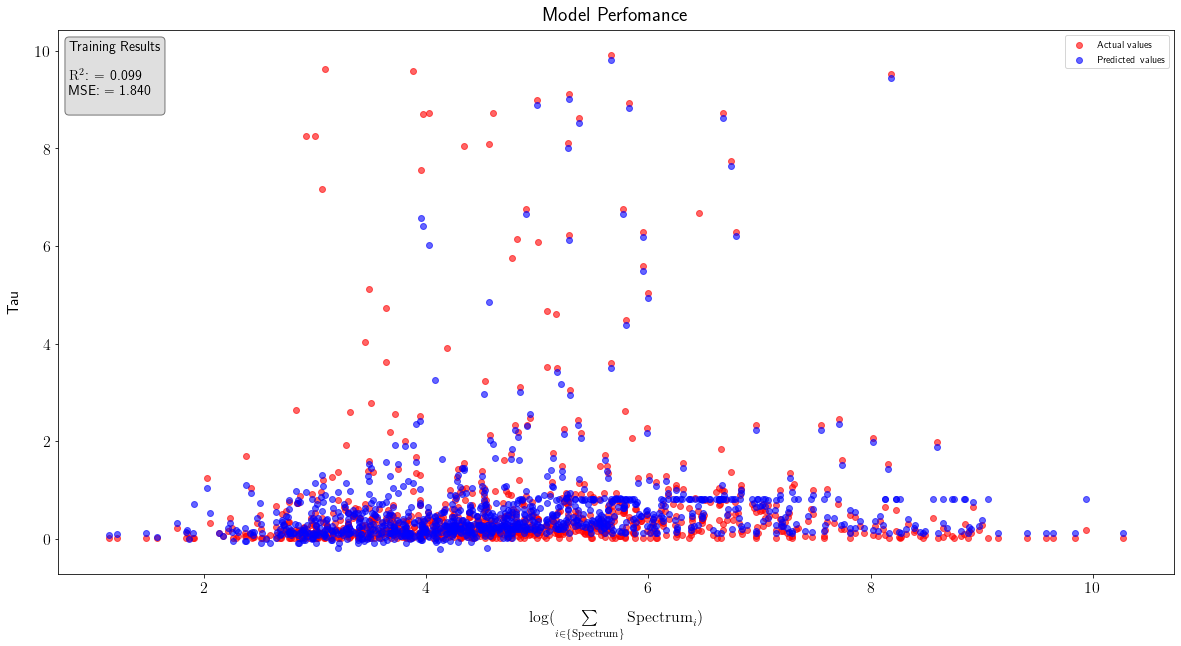

In [16]:
plot_model_performance(spectra_X, tau, estimator.predict(spectra), 'Tau', scores=scores, save_fig=True)

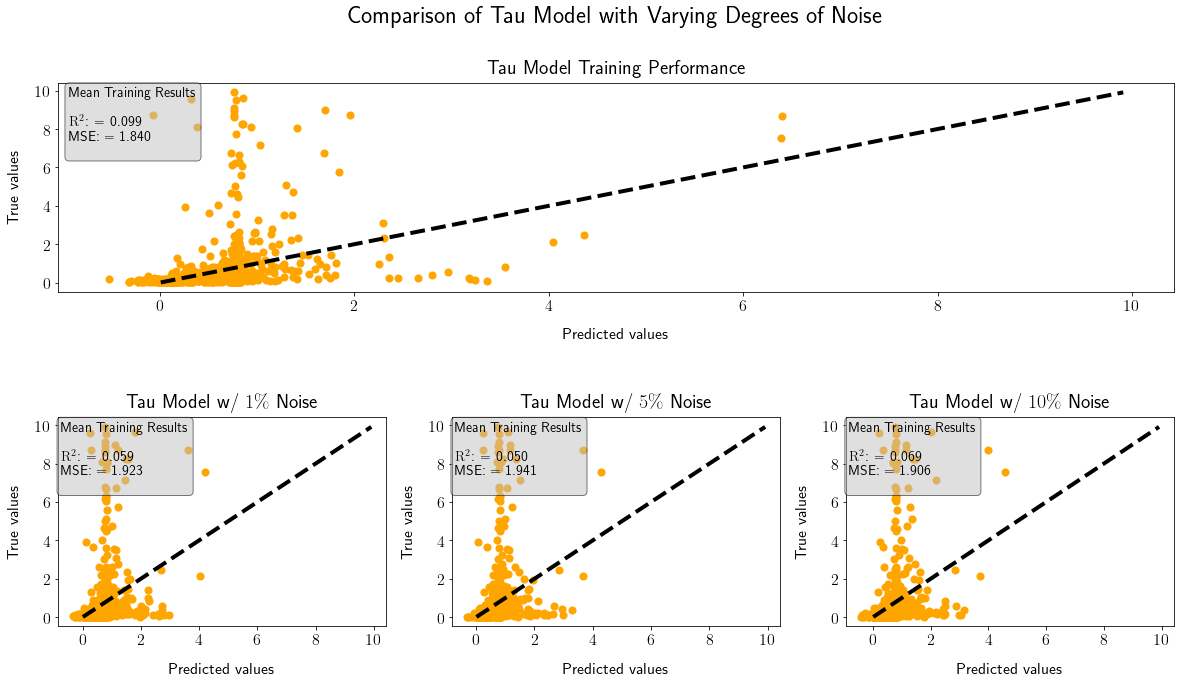

In [17]:
plot_noise_together(tau_model, tau, "Tau", cv)

---
## Predicting Mass

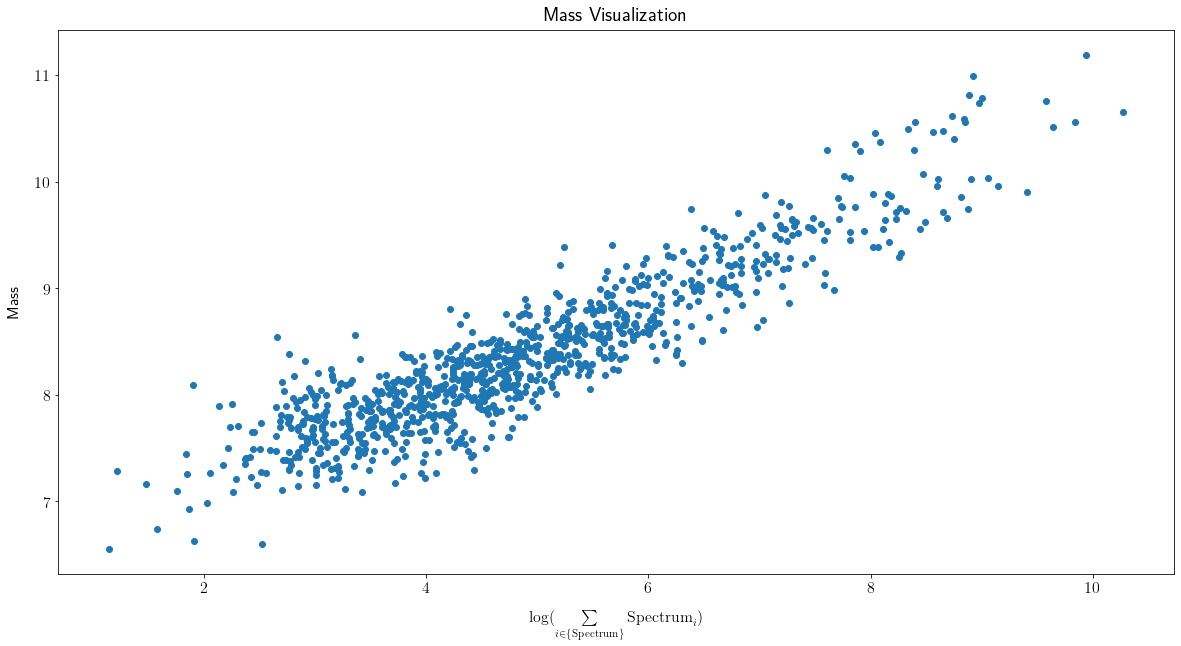

In [18]:
mass = galaxy_properties['mass']
visualize(mass, 'Mass', 'Mass Visualization', save_fig=True)

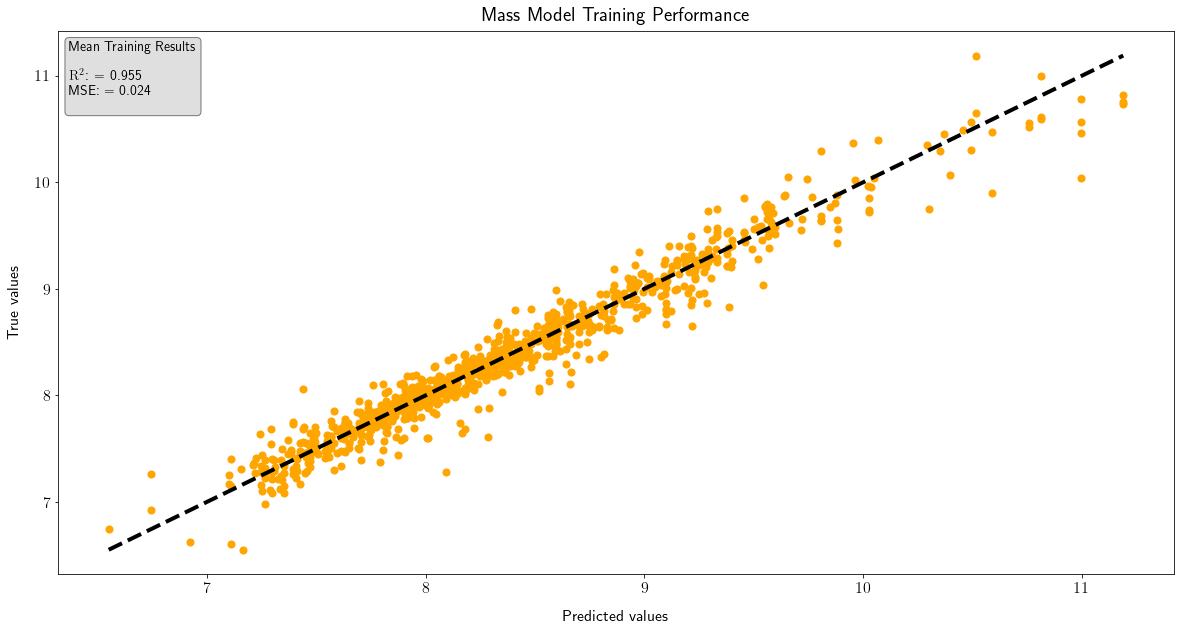

In [19]:
from sklearn.tree import DecisionTreeRegressor

mass_model = DecisionTreeRegressor(max_features=803)
cv_scores = cross_validate(mass_model, spectra, mass, cv=cv, scoring=['r2', 'neg_mean_squared_error'], n_jobs=-1, return_estimator=True)
prediction = cross_val_predict(mass_model, spectra, mass, cv=cv, n_jobs=-1)

estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

scores = {
     '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
     'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
}

plot_model_training_performance(mass, prediction, label='Mass', scores=scores, save_fig=True)

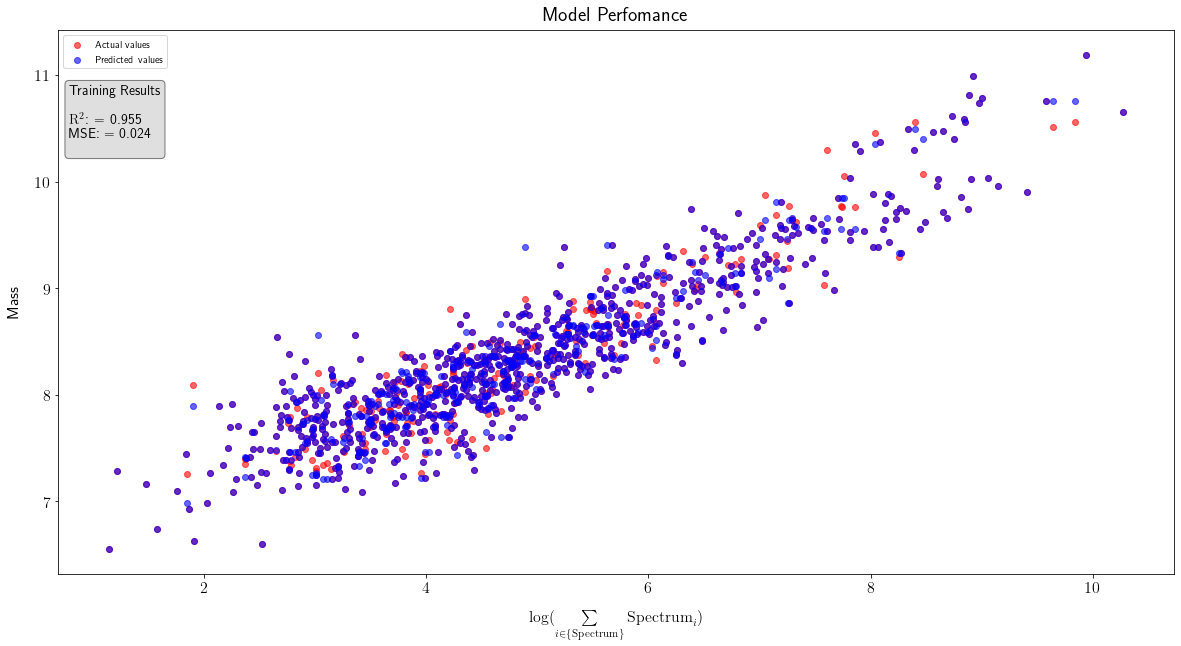

In [20]:
plot_model_performance(spectra_X, mass, estimator.predict(spectra), 'Mass', scores=scores, scores_loc=(0.01, 0.90), save_fig=True)

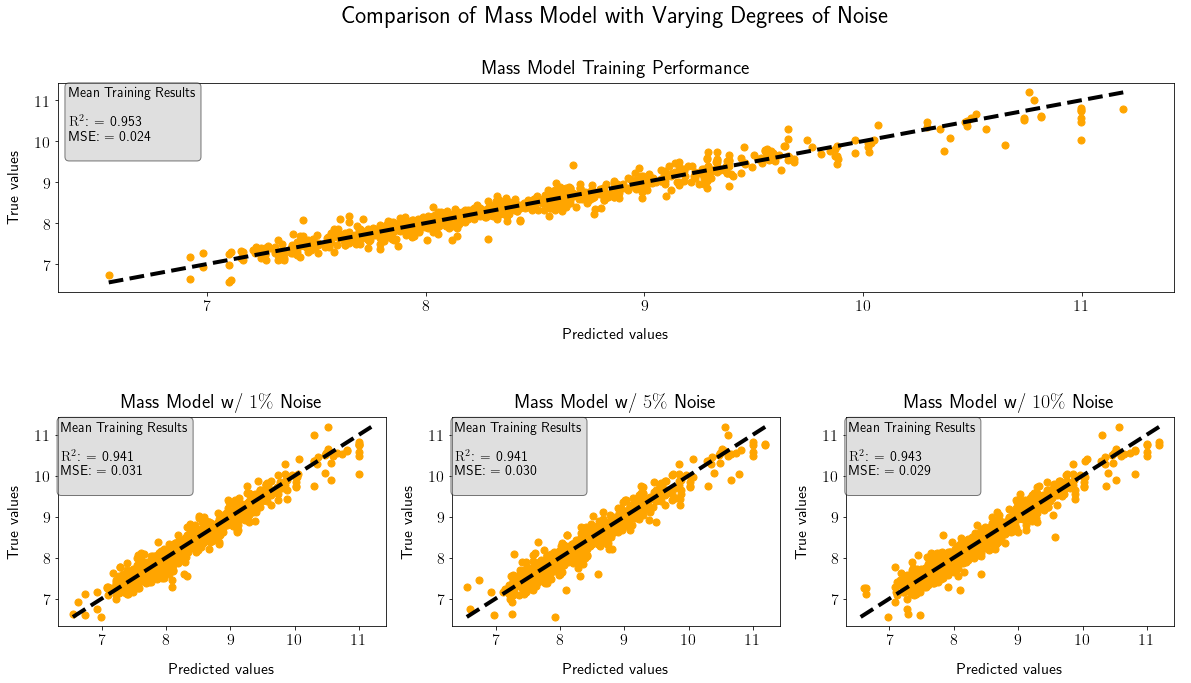

In [21]:
plot_noise_together(mass_model, mass, "Mass", cv)

---
## Predicting Dust

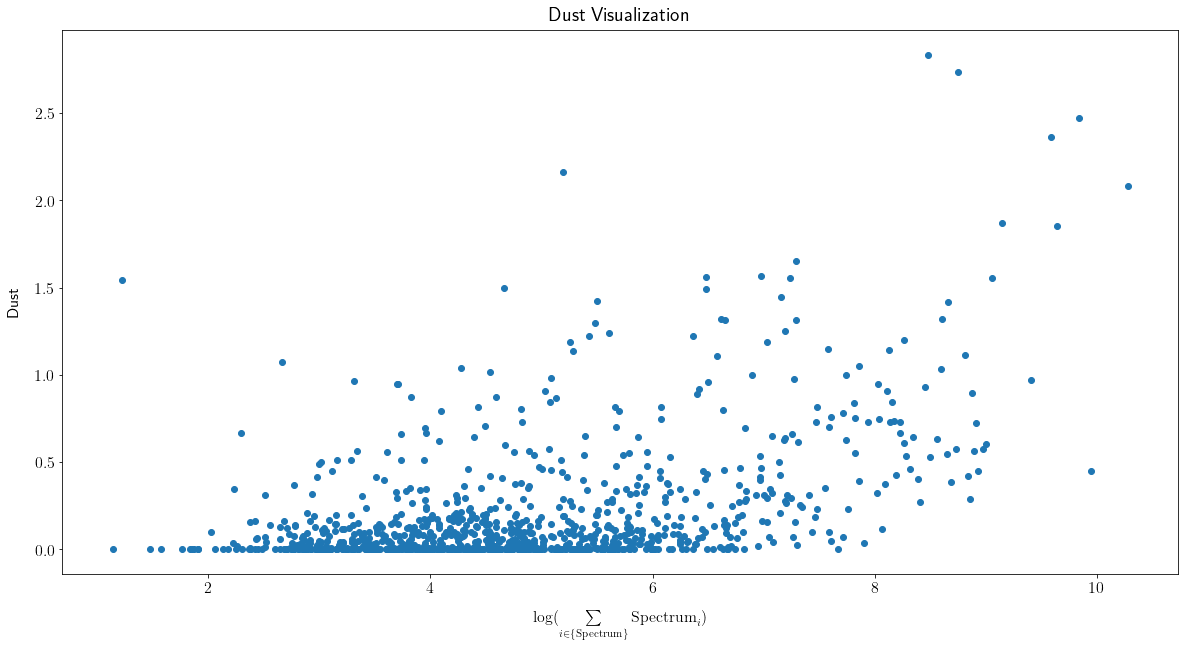

In [22]:
dust = galaxy_properties['dust_av']
visualize(dust, 'Dust', 'Dust Visualization', save_fig=True)

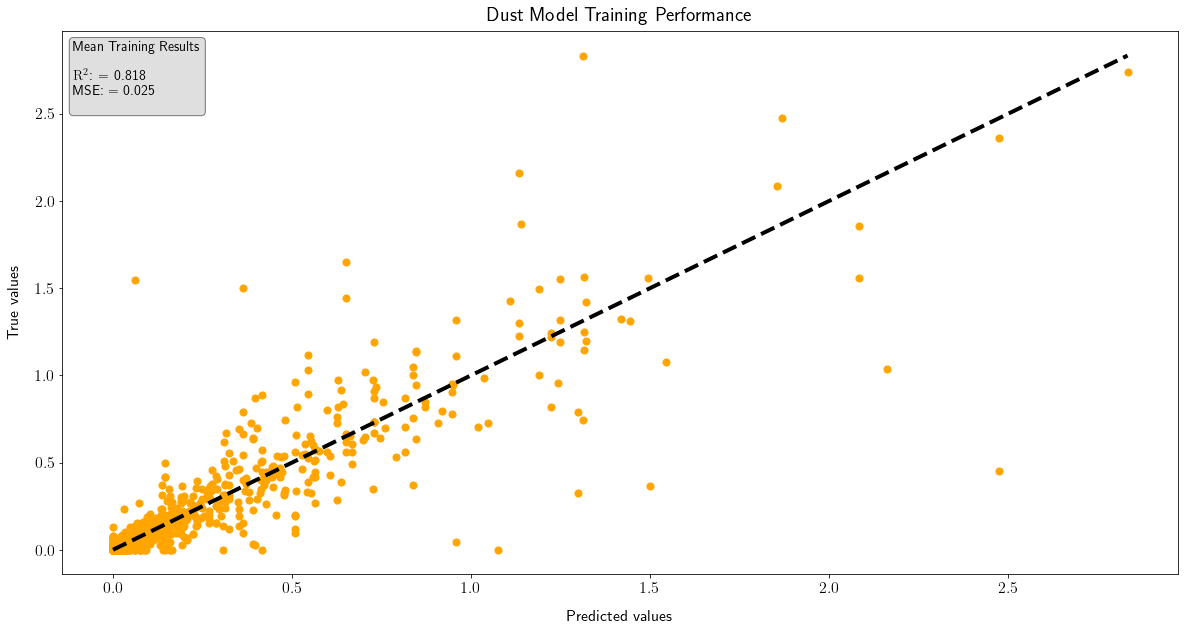

In [23]:
dust_model = DecisionTreeRegressor(max_features=800)
cv_scores = cross_validate(dust_model, spectra, dust, cv=cv, scoring=['r2', 'neg_mean_squared_error'], n_jobs=-1, return_estimator=True)
prediction = cross_val_predict(dust_model, spectra, dust, cv=cv, n_jobs=-1)

estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

scores = {
     '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
     'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
}

plot_model_training_performance(dust, prediction, label='Dust', scores=scores, save_fig=True)

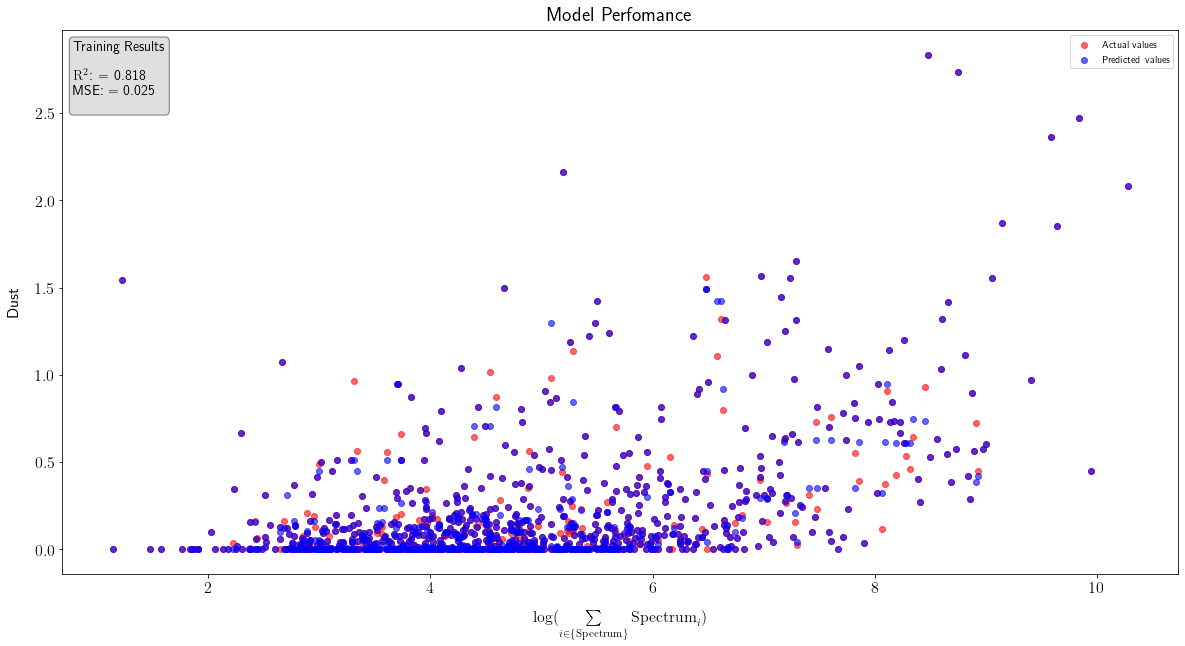

In [24]:
plot_model_performance(spectra_X, dust, estimator.predict(spectra), 'Dust', scores=scores, save_fig=True)

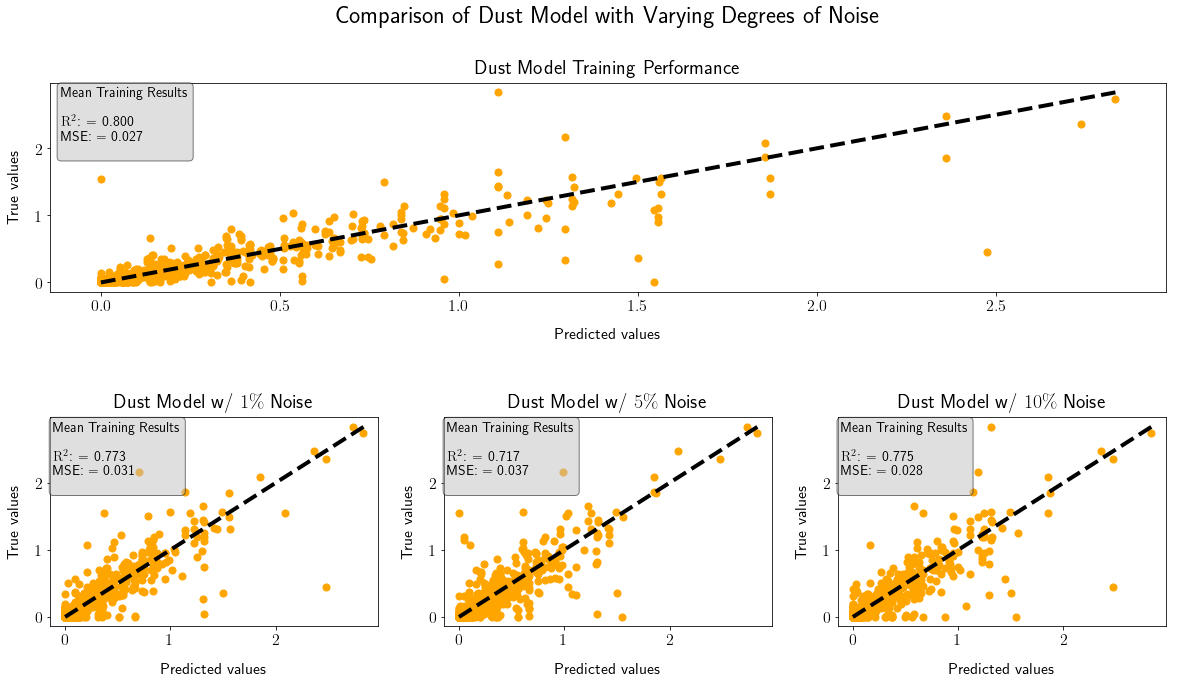

In [25]:
plot_noise_together(dust_model, dust, "Dust", cv)

---
## Conclusion

Adding noise levels does not improve the algorithm’s ability to predict properties. We could get better results  by using more advanced machine learning techniques like a combination of convolutional neural networks and advanced simulations. Since we’ve figured that this simulated  data is coming from an extensive series of images of a galaxy. According to our results, spectral energy distribution graphs do a good job at predicting mass, age and dust, but are not very helpful for obtaining tau.  Additional data and formulas would help our models provide a better and accurate prediction for tau.

---
## References

- Acquaviva, Viviana. -  _Class Notes_
- “API Reference.” Scikit-Learn, scikit-learn.org/stable/modules/classes.html. 
- Behroozi, Peter S., et al. “THE AVERAGE STAR FORMATION HISTORIES OF GALAXIES IN DARK MATTER HALOS FROMz= 0-8.” The Astrophysical Journal, vol. 770, no. 1, 2013, p. 57., doi:10.1088/0004-637x/770/1/57.
- Leja, Joel, et al. “Deriving Physical Properties from Broadband Photometry with Prospector: Description of the Model and a Demonstration of Its Accuracy Using 129 Galaxies in the Local Universe.” The Astrophysical Journal, vol. 837, no. 2, 2017, p. 170., doi:10.3847/1538-4357/aa5ffe.
- Lovell, Christopher C, et al. “Learning the Relationship between Galaxies Spectra and Their Star Formation Histories Using Convolutional Neural Networks and Cosmological Simulations.” Monthly Notices of the Royal Astronomical Society, vol. 490, no. 4, 2019, pp. 5503–5520., doi:10.1093/mnras/stz2851.
- “Matplotlib 3.2.1 Documentation.” Matplotlib, matplotlib.org/3.2.1/contents.html. 
- Various StackOverflow posts